In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

In [2]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p1.csv')

In [4]:
df

,sex,age,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel,absences
0,F,18,A,4,4,mother,2,2,0,3,4,2
1,F,17,T,1,1,father,1,2,0,3,5,1
2,F,15,T,1,1,mother,1,2,3,3,4,3
3,F,15,T,4,2,mother,1,3,0,2,3,0
4,F,16,T,3,3,father,1,2,0,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
390,M,20,A,2,2,other,1,2,2,5,5,4
391,M,17,T,3,1,mother,2,1,0,4,2,1
392,M,21,T,1,1,other,1,1,3,5,5,1
393,M,18,T,3,2,mother,3,1,0,4,4,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sex         395 non-null    object
 1   age         395 non-null    int64 
 2   pstatus     395 non-null    object
 3   medu        395 non-null    int64 
 4   fedu        395 non-null    int64 
 5   guardian    395 non-null    object
 6   traveltime  395 non-null    int64 
 7   studytime   395 non-null    int64 
 8   failures    395 non-null    int64 
 9   freetime    395 non-null    int64 
 10  famrel      395 non-null    int64 
 11  absences    395 non-null    int64 
dtypes: int64(9), object(3)
memory usage: 37.2+ KB


In [6]:
df.isna().sum()

sex           0
age           0
pstatus       0
medu          0
fedu          0
guardian      0
traveltime    0
studytime     0
failures      0
freetime      0
famrel        0
absences      0
dtype: int64

In [7]:
df.describe()

,age,medu,fedu,traveltime,studytime,failures,freetime,famrel,absences
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.235443,3.944304,1.377215
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.998862,0.896659,1.555076
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,3.000000,4.000000,0.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,3.000000,4.000000,1.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,4.000000,5.000000,3.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,4.000000


In [8]:
obj_col = [col for col in df.columns if df[col].dtypes == 'object']
obj_col

['sex', 'pstatus', 'guardian']

In [9]:
num_col = [col for col in df.columns if col not in obj_col]
num_col

['age',
 'medu',
 'fedu',
 'traveltime',
 'studytime',
 'failures',
 'freetime',
 'famrel',
 'absences']

sex, pstatus, guardian은 object형 범주형 변수이고, age, medu, fedu, traveltime, studytime, failures, freetime, famrel, absences는 순서형 변수로 볼 수 있다. 결측치는 없으며 기술통계표만을 참고했을 때 이상값을 특정할 수 없기 때문에 각 데이터의 분포를 살펴볼 필요가 있다.

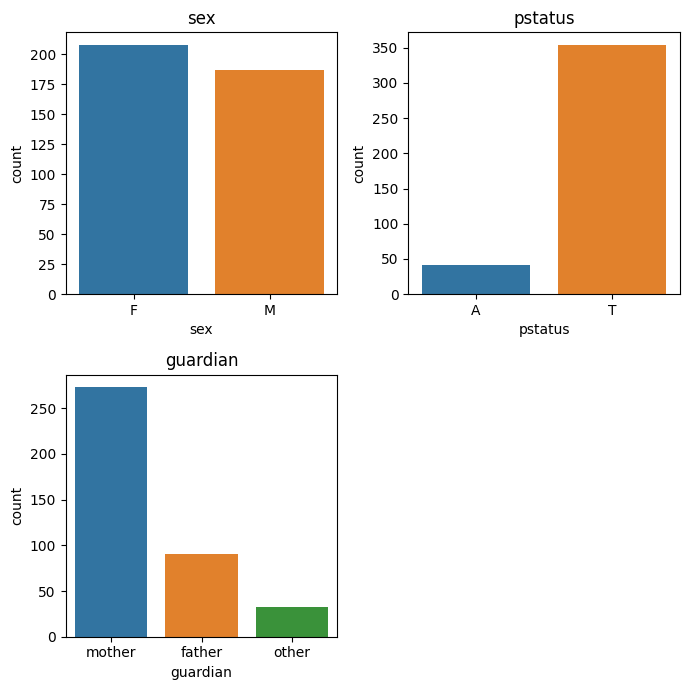

In [10]:
plt.figure(figsize=(7, 7))

for idx, col in enumerate(obj_col):
    plt.subplot(2, 2, idx+1)
    plt.title(col)
    sns.countplot(x=df[col])
    
plt.tight_layout()
plt.show();

object형 변수들은 sex 변수를 제외하고는 데이터가 불균형함을 확인할 수 있다.

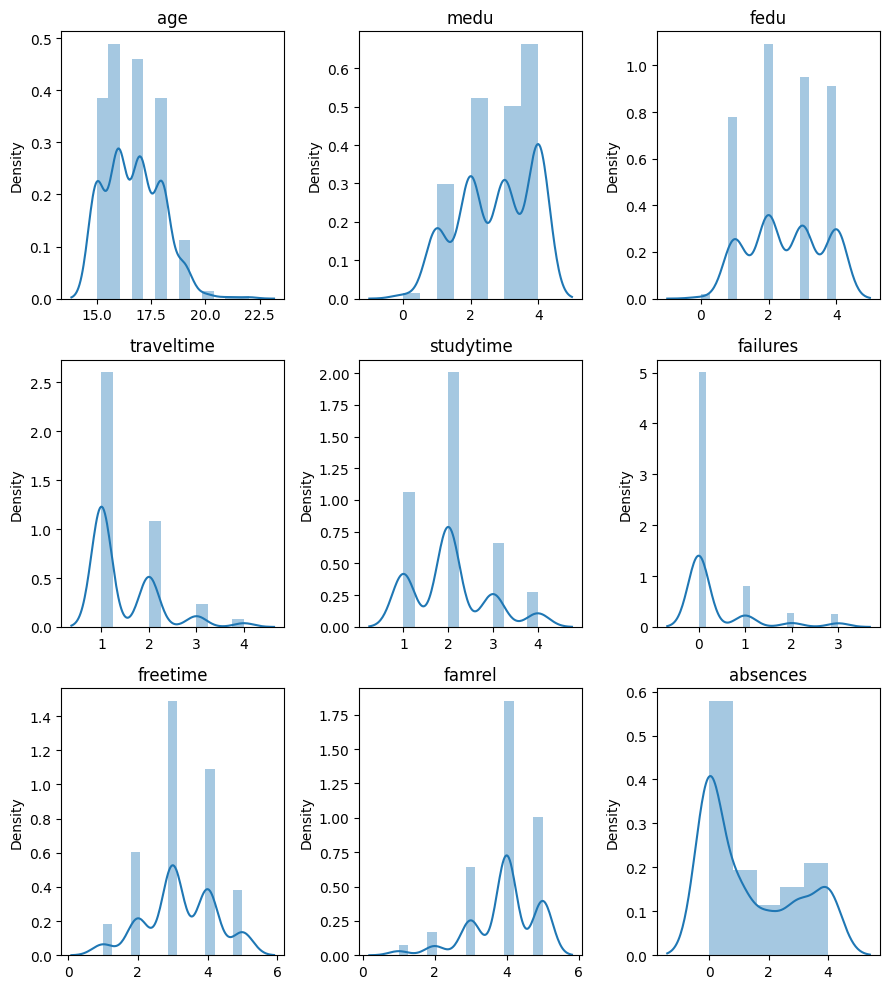

In [11]:
plt.figure(figsize=(9, 10))

for idx, col in enumerate(num_col):
    plt.subplot(3, 3, idx+1)
    plt.title(col)
    sns.distplot(x=df[col])
    
plt.tight_layout()
plt.show();

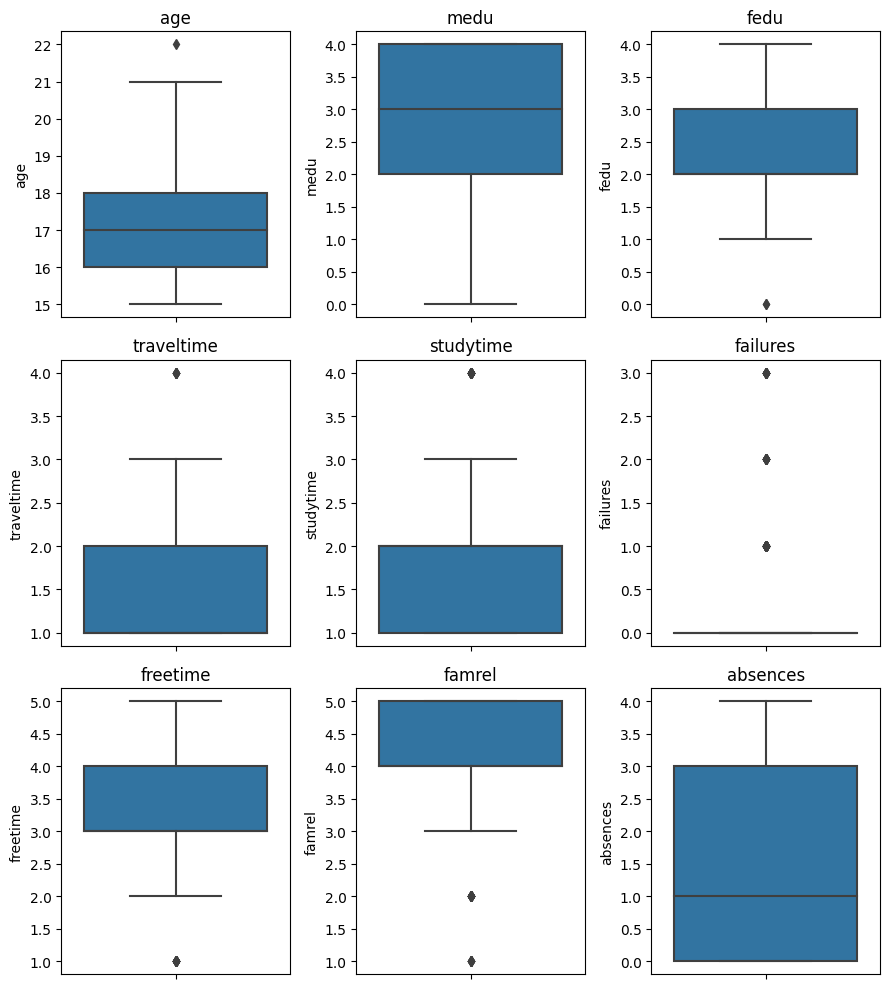

In [12]:
plt.figure(figsize=(9, 10))

for idx, col in enumerate(num_col):
    plt.subplot(3, 3, idx+1)
    plt.title(col)
    sns.boxplot(y=df[col])
    
plt.tight_layout()
plt.show();

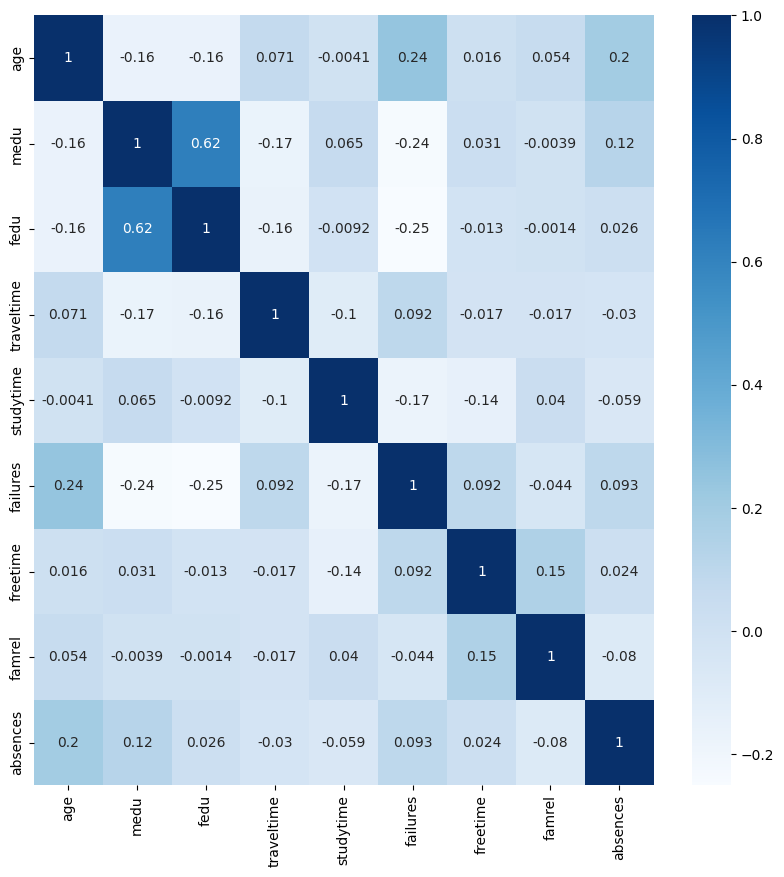

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.show();

medu와 fedu 간 양의 상관성을 보이고 있으며, 그 외 강한 상관성을 보이는 변수는 없다.

In [14]:
x = df[num_col].drop(columns=['absences'])

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

VIF = sorted([(variance_inflation_factor(x.values, idx), col) for idx, col in enumerate(x.columns)], reverse=True, key=lambda x: x[0])
VIF

[(42.11270688310318, 'age'),
 (20.284486138952822, 'famrel'),
 (12.126028448969688, 'medu'),
 (11.745200461605396, 'freetime'),
 (10.568286654465934, 'fedu'),
 (7.191209049868786, 'studytime'),
 (5.427647092586933, 'traveltime'),
 (1.4017225871000396, 'failures')]

차원축소의 필요성을 확인하기 위해 VIF를 확인해본 결과 순서대로 age, famrel, medu, freetime, fedu 변수의 VIF 값이 10 이상임을 확인했다. 따라서 다중공선성 제거를 위해 차원축소가 필요하다.

In [27]:
obj_col

['sex', 'pstatus', 'guardian']

## 1-2

데이터 품질 개선을 위해 object형 변수를 인코딩한다. sex, pstatus는 두 개의 범주이고, guardian만 세 개의 범주이므로 Label 인코딩을 진행한다.

In [29]:
for col in obj_col:
    print(f'{col} 컬럼은 {({data:idx for idx, data in enumerate(df[col].unique())})}로 인코딩')
    df[col] = df[col].map({data:idx for idx, data in enumerate(df[col].unique())})
    
df[obj_col]

sex 컬럼은 {'F': 0, 'M': 1}로 인코딩
pstatus 컬럼은 {'A': 0, 'T': 1}로 인코딩
guardian 컬럼은 {'mother': 0, 'father': 1, 'other': 2}로 인코딩


,sex,pstatus,guardian
0,0,0,0
1,0,1,1
2,0,1,0
3,0,1,0
4,0,1,1
...,...,...,...
390,1,0,2
391,1,1,0
392,1,1,2
393,1,1,0


In [30]:
df

,sex,age,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel,absences
0,0,18,0,4,4,0,2,2,0,3,4,2
1,0,17,1,1,1,1,1,2,0,3,5,1
2,0,15,1,1,1,0,1,2,3,3,4,3
3,0,15,1,4,2,0,1,3,0,2,3,0
4,0,16,1,3,3,1,1,2,0,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,20,0,2,2,2,1,2,2,5,5,4
391,1,17,1,3,1,0,2,1,0,4,2,1
392,1,21,1,1,1,2,1,1,3,5,5,1
393,1,18,1,3,2,0,3,1,0,4,4,0


In [34]:
from collections import Counter 

In [35]:
Counter(df.absences)

Counter({2: 36, 1: 61, 3: 49, 0: 183, 4: 66})

## 1-3